# Joining of Datasets on Brand Name

In [72]:
import importlib

import analysis_code.myevaluation
importlib.reload(analysis_code.myevaluation)
import analysis_code.myevaluation as myevaluation

import analysis_code.myutils
importlib.reload(analysis_code.myutils)
import analysis_code.myutils as myutils

import analysis_code.mypytable
importlib.reload(analysis_code.mypytable)
from analysis_code.mypytable import MyPyTable 

import analysis_code.myclassifiers
importlib.reload(analysis_code.myclassifiers)
from analysis_code.myclassifiers import MyKNeighborsClassifier, MyNaiveBayesClassifier

#import analysis_code.plot_utils
#importlib.reload(analysis_code.plot_utils)

import tabulate
from tabulate import tabulate
import numpy as np

In [18]:
raw_data = MyPyTable()
raw_data2 = MyPyTable()
X = []
Y = []
raw_data = raw_data.load_from_file("california_cosmetics.csv")
raw_data2 = raw_data2.load_from_file("cosmetics_kaggle.csv")
data_joined = raw_data.perform_inner_join(raw_data2, ["BrandName"])
duplicates = data_joined.find_duplicates(["BrandName"])
data_joined.drop_rows(duplicates)
data_joined.save_to_file("cosmetics_clean.csv")
row, col = data_joined.get_shape()
print("number of rows ", row)
print("number of cols ", col)

number of rows  13
number of cols  32


#### Based on the lack of matching columns we decided to move away from using the cosmetics kaggle data set and instead are splitting the data set in order to test our classifiers. The size of our dataset is sufficient due to it being more than 100,000 entries that need to be sorted through.

In [39]:
subset = MyPyTable().load_from_file("cali_subset.csv")
row, col = subset.get_shape()
print("number of rows ", row)
print("number of cols ", col)

number of rows  499
number of cols  22


In [40]:
subset = subset.remove_rows_with_missing_values()
row, col = subset.get_shape()
print("number of rows ", row)
print("number of cols ", col)

number of rows  499
number of cols  22


In [73]:
y = subset.get_column("ChemicalName")
columns = ["CompanyName", "BrandName", "PrimaryCategory", "SubCategory"]
X = []
for i in range(len(subset.data)):
    instance_data = []
    for col in columns:
        instance_data.append(subset.get_column(col)[i])
    X.append(instance_data)

In [47]:
#initializing classifiers
naive_class = MyNaiveBayesClassifier()
knn_class = MyKNeighborsClassifier()
#splitting data
split = myevaluation.stratified_kfold_split(X, y, 10, 0)
y_tests = []
y_pred_naive = []
y_pred_knn = []
#training the data and then predicting on test sets
for fold in split:
    X_train, X_test, y_train, y_test = myutils.get_train_test(X, y, fold)
    naive_class.fit(X_train, y_train)
    knn_class.fit(X_train, y_train)
    y_pred_naive.extend(naive_class.predict(X_test))
    y_pred_knn.extend(knn_class.predict(X_test))
    y_tests.extend(y_test)

In [48]:
#printing the metrics
print("================================================")
print("Naive Bayes Metrics")
print("================================================")
myutils.print_metrics(y_pred_naive, y_tests)
print("================================================")
print("kNN Metrics")
print("================================================")
myutils.print_metrics(y_pred_knn, y_tests)

Naive Bayes Metrics
Accuracy: 0.94
Error Rate: 0.06
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
                                                                                                       Butylated hydroxyanisole    Chromium (hexavalent compounds)    Cocamide diethanolamine    Coffea arabica extract    Distillates (coal tar)    Estragole    Retinol    Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.    Titanium dioxide    Toluene    Vitamin A    Vitamin A palmitate    Total  Recognition (%)
---------------------------------------------------------------------------------------------------  --------------------------  ---------------------------------  -------------------------  ------------------------  ------------------------  -----------  ---------  -----------------------------------------------------------------------------------------------------  ------------------  ---------  -----------  -------------

In [ ]:
#printing the classification report (bonus)
print("================================================")
print("Naive Bayes Report")
print("================================================")
print(myevaluation.classification_report(y_tests, y_pred_naive, False))
print("================================================")
print("kNN Report")
print("================================================")
print(myevaluation.classification_report(y_tests, y_pred_knn, False))

Naive Bayes Report
+-----------------------------------------------------------------------------------------------------+-------------+----------+------------+-----------+
|                                                                                                     | precision   | recall   |   f1-score |   support |
+=====================================================================================================+=============+==========+============+===========+
| Butylated hydroxyanisole                                                                            | 0.0         | 0.0      |       0    |         2 |
+-----------------------------------------------------------------------------------------------------+-------------+----------+------------+-----------+
| Chromium (hexavalent compounds)                                                                     | 0.0         | 0.0      |       0    |         1 |
+--------------------------------------------------------

# Data Visualization

493


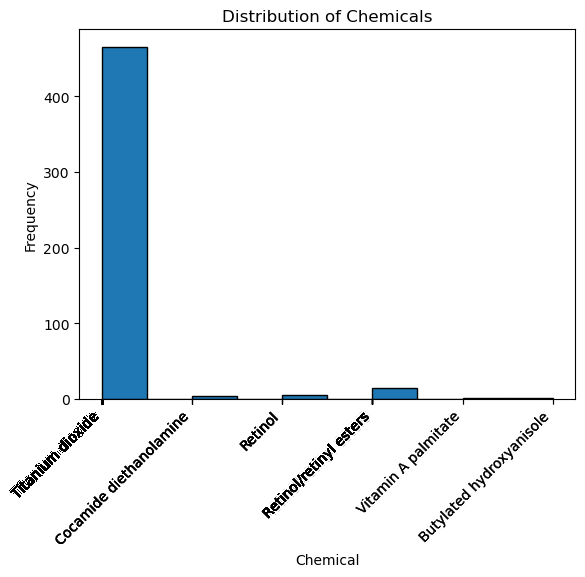

In [75]:
for i, label in enumerate(y):
    if label == "Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.":
        y[i] = "Retinol/retinyl esters"
values, counts = myutils.get_frequency(y)
for i, val in enumerate(values):
    if counts[i] < 2:
        for inst in y:
            if inst == val:
                y.remove(inst)
print(len(y))
myutils.histogram(y, "Chemical", "Frequency", "Distribution of Chemicals", xticks=y)